# 1. Scraping data dari google play store

In [ ]:
!pip install google_play_scraper

In [ ]:
from google_play_scraper import app
import pandas as pd
import numpy as np

In [ ]:
#mengambil data ulasan bahasa inggris, berdasarkan paling relevan, dan 50000 data
from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    'com.instagram.android',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    count=5000, # defaults to 5000
    filter_score_with=None
)

In [ ]:
# membuat data frame
df_busu = pd.DataFrame(np.array(result),columns=['review'])

df_busu = df_busu.join(pd.DataFrame(df_busu.pop('review').tolist()))

df_busu.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,ff4475d9-7195-485e-a3a2-80f0c88bbe48,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,What is the point of 10 photos for a reel all ...,1,145,358.0.0.51.97,2024-11-26 14:51:10,None,NaT,358.0.0.51.97
1,fedc3bc9-1cb7-432b-8255-37939364620d,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Usually, I love this app. Just experiencing ma...",3,842,357.1.0.52.100,2024-11-19 04:21:00,None,NaT,357.1.0.52.100
2,a3bb6c14-e5c5-4f56-b016-e3912c09159b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"I love this app, but it seems like every time ...",2,202,358.0.0.51.97,2024-11-25 06:09:00,None,NaT,358.0.0.51.97
3,677fc74a-eb35-431c-9f87-af58b898f17f,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"It's always a new, unexplainable problem with ...",2,144,358.0.0.51.97,2024-11-24 19:59:14,None,NaT,358.0.0.51.97
4,3921227a-8b5e-4d7a-9901-73c26f6334b3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This app is perfect when you want to see 10 ad...,2,39,357.1.0.52.100,2024-11-25 04:13:26,None,NaT,357.1.0.52.100


In [ ]:
#data yang dibutuhkan score dan content
my_df = df_busu[[ 'score', 'content']]
my_df.head()

,score,content
0,1,What is the point of 10 photos for a reel all ...
1,3,"Usually, I love this app. Just experiencing ma..."
2,2,"I love this app, but it seems like every time ..."
3,2,"It's always a new, unexplainable problem with ..."
4,2,This app is perfect when you want to see 10 ad...


In [ ]:
#memastikan jumlah ulasan yang dimabil
len(my_df.index)

5000

In [ ]:
 #menyimpan data dalam bentuk csv
my_df.to_csv("scraping_instagram_en.csv", index = False)

# 2. Pre Processing

2.1 Case Folding (mengubah huruf kapital menjadi huruf kecil) dan Cleansing (menghilangkan simbol dan angka tidak penting)

ini bener

In [ ]:
#import library
import re
import string

In [ ]:
def clean_text(my_df, text_field, new_text_field_name):
    # Case folding: mengubah huruf besar ke kecil
    my_df[new_text_field_name] = my_df[text_field].str.lower()

    # Mengubah tipe data menjadi string
    my_df[new_text_field_name] = my_df[new_text_field_name].astype(str)

    # Menjaga kontraksi (apostrof) sebelum pembersihan
    # Ganti apostrof dalam kontraksi seperti "I'm", "I've" menjadi _apos_
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"\b(?:i'm|i've|we're|don't|can't|isn't|it's|you're)\b",
                           lambda match: match.group(0).replace("'", "_apos_"), elem)
    )

    # Menghilangkan simbol dan karakter non-alfabet, angka, dan URL
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"[^a-zA-Z0-9\s_apos_]", " ", elem)
    )

    # Menghilangkan angka
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"\d+", " ", elem)
    )

    # Menghilangkan URL
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"http\S+|www\S+|https\S+", "", elem, flags=re.MULTILINE)
    )

    # Menghilangkan karakter non-ASCII
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r'[^\x00-\x7F]+', '', elem)
    )

    # Menghilangkan tanda baca dan simbol lainnya
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r'[^\w\s_apos_]', '', elem)
    )

    # Menghilangkan tab, newline, dan backslash
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"[\t\n\r\\]+", " ", elem)
    )

    # Menghilangkan spasi di awal dan akhir serta merapikan spasi berlebih menjadi satu spasi
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: re.sub(r"\s+", " ", elem).strip()
    )

    # Mengganti kembali placeholder '_apos_' ke tanda petik (apostrof)
    my_df[new_text_field_name] = my_df[new_text_field_name].apply(
        lambda elem: elem.replace("_apos_", "'")
    )

    return my_df

In [ ]:
my_df['case_folding'] = my_df['content'].str.lower()
my_df['case_folding']
data_clean = clean_text(my_df, 'content', 'case_folding')

<ipython-input-10-df14b5fb2fff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df['case_folding'] = my_df['content'].str.lower()
<ipython-input-9-6e2edcce28f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df[new_text_field_name] = my_df[text_field].str.lower()
<ipython-input-9-6e2edcce28f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
data_clean.head(10)

,score,content,case_folding
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...
5,3,Recently my Instagram has stopped playing audi...,recently my instagram has stopped playing audi...
6,1,App is unusable now because of bugs. I don't k...,app is unusable now because of bugs i don't kn...
7,2,"I enjoyed Insta for years, but the last few up...",i enjoyed insta for years but the last few upd...
8,2,The newest update doesn't allow me to adjust t...,the newest update doesn t allow me to adjust t...
9,2,I'm seeing a couple of issues for the app. Fir...,i'm seeing a couple of issues for the app firs...


In [ ]:
data_clean = data_clean.drop('case_folding', axis=1, errors='ignore')

2. tokenizing

In [ ]:
import nltk
import re
from nltk.tokenize import word_tokenize

# Download resource yang dibutuhkan
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#BAWAH INI JANGAN DIPAKE
data_clean = data_clean.drop('tokenizing', axis=1, errors='ignore')

tokenizing yg benar

In [ ]:
# Fungsi untuk memperbaiki kontraksi
def fix_contractions(text):
    # Daftar kontraksi yang umum
    contractions_dict = {
        r"\bI'm\b": "I'm", r"\bI've\b": "I've", r"\bIt's\b": "It's",
        r"\bYou're\b": "You're", r"\bHe's\b": "He's", r"\bShe's\b": "She's",
        r"\bWe've\b": "We've", r"\bThey're\b": "They're", r"\bCan't\b": "Can't",
        r"\bDon't\b": "Don't", r"\bDidn't\b": "Didn't", r"\bIsn't\b": "Isn't",
        r"\bWasn't\b": "Wasn't", r"\bAren't\b": "Aren't"
    }

    # Terapkan regex untuk setiap kontraksi dalam dictionary
    for contraction, fixed in contractions_dict.items():
        text = re.sub(contraction, fixed, text)

    return text

# Tokenisasi yang lebih hati-hati tanpa pemisahan kontraksi yang tidak diinginkan
def process_tokenization(text):
    # Perbaiki kontraksi terlebih dahulu
    text = fix_contractions(text)

    # Tokenisasi menggunakan regex yang lebih sederhana
    tokens = re.findall(r"\b\w+'\w+|\w+|[^\w\s]", text)

    return tokens
# Terapkan fungsi pada data yang sudah dibersihkan
data_clean['tokenizing'] = data_clean['case_folding'].apply(lambda x: process_tokenization(x))

# Menampilkan 10 data teratas setelah tokenisasi
data_clean.head(10)

TypeError: expected string or bytes-like object

In [ ]:
#BAWAH INI JANGAN DIPAKE
data_clean = data_clean.drop('tokenizing', axis=1, errors='ignore')

In [ ]:
data_clean.head()

,score,content,case_folding,tokenizing
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...,"[usually, i, love, this, app, just, experienci..."
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...,"[too, many, ads, can't, even, see, friends, pr..."
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,..."
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...,"[i, love, this, app, and, honestly, might, be,..."
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial..."


In [ ]:
sorted_data = data_clean[['score', 'tokenizing']]
sorted_data.head()

,score,tokenizing
0,3,"[usually, i, love, this, app, just, experienci..."
1,1,"[too, many, ads, can't, even, see, friends, pr..."
2,2,"[it's, starting, to, go, down, hill, whenever,..."
3,3,"[i, love, this, app, and, honestly, might, be,..."
4,3,"[i've, reduced, usage, on, this, app, especial..."


In [ ]:
sorted_data.to_csv('tokenizing.csv', index = False)

In [ ]:
data_clean.to_csv('preprocessing2.csv', index = False)

3. normalize

In [ ]:
#BAWAH INI JANGAN DIPAKE
data_clean = data_clean.drop('tokenizing', axis=1, errors='ignore')

In [ ]:
data_clean.head()

,score,content,case_folding,tokenizing
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...,"[usually, i, love, this, app, just, experienci..."
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...,"[too, many, ads, can't, even, see, friends, pr..."
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,..."
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...,"[i, love, this, app, and, honestly, might, be,..."
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial..."


In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize

# Mendeklarasikan normalization_dict
normalization_dict = {}
normalization_dict.update({
    'thanks': 'thank you',
    'pls': 'please',
    'thx': 'thank you',
    'sorry': 'apologies',
    'omg': 'oh my god',
    'lol': 'laugh out loud',
    'brb': 'be right back',
    'btw': 'by the way',
    'idk': 'i don’t know',
    'tbh': 'to be honest',
    'lmao': 'laughing my ass off',
    'fyi': 'for your information',
    'sry': 'sorry',
    'smh': 'shaking my head',
    'rofl': 'rolling on the floor laughing',
    'asap': 'as soon as possible',
    'bff': 'best friends forever',
    'fomo': 'fear of missing out',
    'yolo': 'you only live once',
    'gtg': 'got to go',
    'nvm': 'never mind',
    'np': 'no problem',
    'cya': 'see you',
    'gg': 'good game',
    'wfh': 'work from home',
    'ftw': 'for the win',
    'lmk': 'let me know',
    'tmi': 'too much information',
    'bbl': 'be back later',
    'mfw': 'my face when',
    'imo': 'in my opinion',
    'atm': 'at the moment',
})

# Fungsi untuk normalisasi
def normalize_token(token, normalization_dict):
    if "'" in token:  # Memastikan token tidak mengandung tanda petik satu
        return token
    return normalization_dict.get(token, token)  # Kembalikan token yang sudah dinormalisasi atau token asli

# Menggunakan tokenisasi dan normalisasi
data_clean['normalized'] = data_clean['tokenizing'].apply(
    lambda x: [normalize_token(word, normalization_dict) for word in x]
)

data_clean.head()

<ipython-input-19-bfbb2f83d728>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['normalized'] = data_clean['tokenizing'].apply(


,score,content,case_folding,tokenizing,normalized
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...,"[usually, i, love, this, app, just, experienci...","[usually, i, love, this, app, just, experienci..."
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...,"[too, many, ads, can't, even, see, friends, pr...","[too, many, ads, can't, even, see, friends, pr..."
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,...","[it's, starting, to, go, down, hill, whenever,..."
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...,"[i, love, this, app, and, honestly, might, be,...","[i, love, this, app, and, honestly, might, be,..."
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial...","[i've, reduced, usage, on, this, app, especial..."


stopword removal (sastrawi dan nltk)

In [ ]:
#BAWAH INI JANGAN DIPAKE
data_clean = data_clean.drop('stemming', axis=1, errors='ignore')

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

# Pastikan Anda sudah mengimpor stopwords dan PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')

# Inisialisasi stop words dan stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Fungsi untuk menghapus stop words, stemming, dan menghapus tanda baca
def preprocess_text(tokens):
    # Menghapus stop words dan tanda baca, serta melakukan stemming
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens

# Terapkan preprocessing pada kolom 'tokenizing'
data_clean['stopwword'] = data_clean['normalized'].apply(preprocess_text)

# Menampilkan hasil
data_clean.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-20-3134ce5f48da>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['stopwword'] = data_clean['normalized'].apply(preprocess_text)


,score,content,case_folding,tokenizing,normalized,stopwword
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...,"[usually, i, love, this, app, just, experienci...","[usually, i, love, this, app, just, experienci...","[usual, love, app, experienc, mani, bug, recen..."
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...,"[too, many, ads, can't, even, see, friends, pr...","[too, many, ads, can't, even, see, friends, pr...","[mani, ad, can't, even, see, friend, profil, s..."
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,...","[it's, starting, to, go, down, hill, whenever,...","[start, go, hill, whenev, want, upload, post, ..."
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...,"[i, love, this, app, and, honestly, might, be,...","[i, love, this, app, and, honestly, might, be,...","[love, app, honestli, might, best, connect, fr..."
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial...","[i've, reduced, usage, on, this, app, especial...","[i'v, reduc, usag, app, especi, busi, constant..."


In [ ]:
data_clean.head(10)

,score,content,case_folding,tokenizing,normalized,stopwword
0,1,I'm experiencing some odd behavior in the app....,i'm experiencing some odd behavior in the app ...,"[i'm, experiencing, some, odd, behavior, in, t...","[i'm, experiencing, some, odd, behavior, in, t...","[i'm, experienc, odd, behavior, app, timestamp..."
1,2,Posting process is excruciating. It's either m...,posting process is excruciating it's either my...,"[posting, process, is, excruciating, it's, eit...","[posting, process, is, excruciating, it's, eit...","[post, process, excruci, either, photo, glitch..."
2,1,Glitches and shows blank photos during the edi...,glitches and shows blank photos during the edi...,"[glitches, and, shows, blank, photos, during, ...","[glitches, and, shows, blank, photos, during, ...","[glitch, show, blank, photo, edit, process, st..."
3,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,...","[it's, starting, to, go, down, hill, whenever,...","[start, go, hill, whenev, want, upload, post, ..."
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial...","[i've, reduced, usage, on, this, app, especial...","[i'v, reduc, usag, app, especi, busi, constant..."
5,2,"I enjoyed Insta for years, but the last few up...",i enjoyed insta for years but the last few upd...,"[i, enjoyed, insta, for, years, but, the, last...","[i, enjoyed, insta, for, years, but, the, last...","[enjoy, insta, year, last, updat, photo, edit,..."
6,2,The newest update doesn't allow me to adjust t...,the newest update doesn t allow me to adjust t...,"[the, newest, update, doesn, t, allow, me, to,...","[the, newest, update, doesn, t, allow, me, to,...","[newest, updat, allow, adjust, size, photo, cu..."
7,2,"Yeah, I've had problems with the app. Every ti...",yeah i've had problems with the app every time...,"[yeah, i've, had, problems, with, the, app, ev...","[yeah, i've, had, problems, with, the, app, ev...","[yeah, i'v, problem, app, everi, time, tri, ma..."
8,1,I've been using this app for years. With every...,i've been using this app for years with every ...,"[i've, been, using, this, app, for, years, wit...","[i've, been, using, this, app, for, years, wit...","[i'v, use, app, year, everi, updat, continu, w..."
9,2,Very fun and entertaining. This app is a good ...,very fun and entertaining this app is a good w...,"[very, fun, and, entertaining, this, app, is, ...","[very, fun, and, entertaining, this, app, is, ...","[fun, entertain, app, good, way, pass, time, e..."


Lemmatization

In [ ]:
import spacy

# Inisialisasi model SpaCy
nlp = spacy.load("en_core_web_sm")

# Fungsi untuk melakukan lemmatization
def lemmatize_tokens(tokens):
    lemmatized = [nlp(word)[0].lemma_ for word in tokens]
    return lemmatized

# Terapkan lemmatization pada kolom 'stopwword'
data_clean['lemmatized'] = data_clean['stopwword'].apply(lemmatize_tokens)

# Menampilkan hasil
data_clean.head()

KeyboardInterrupt: 

In [ ]:
#menyatukan ulasan perkata menjadi satu kalimat
data_clean['data_fixed'] = data_clean['lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
data_clean.head()

,score,content,case_folding,tokenizing,normalized,stopwword,lemmatized,data_fixed
0,3,"Usually, I love this app. Just experiencing ma...",usually i love this app just experiencing many...,"[usually, i, love, this, app, just, experienci...","[usually, i, love, this, app, just, experienci...","[usual, love, app, experienc, mani, bug, recen...","[usual, love, app, experienc, mani, bug, recen...",usual love app experienc mani bug recent big b...
1,1,Too many ads. Can't even see friends' profiles...,too many ads can't even see friends profiles s...,"[too, many, ads, can't, even, see, friends, pr...","[too, many, ads, can't, even, see, friends, pr...","[mani, ad, can't, even, see, friend, profil, s...","[mani, ad, can, even, see, friend, profil, sin...",mani ad can even see friend profil sinc get cl...
2,2,It's starting to go down hill. Whenever I want...,it's starting to go down hill whenever i want ...,"[it's, starting, to, go, down, hill, whenever,...","[it's, starting, to, go, down, hill, whenever,...","[start, go, hill, whenev, want, upload, post, ...","[start, go, hill, whenev, want, upload, post, ...",start go hill whenev want upload post show pic...
3,3,I love this app and honestly might be best for...,i love this app and honestly might be best for...,"[i, love, this, app, and, honestly, might, be,...","[i, love, this, app, and, honestly, might, be,...","[love, app, honestli, might, best, connect, fr...","[love, app, honestli, might, good, connect, fr...",love app honestli might good connect friend co...
4,3,I've reduced usage on this app (especially for...,i've reduced usage on this app especially for ...,"[i've, reduced, usage, on, this, app, especial...","[i've, reduced, usage, on, this, app, especial...","[i'v, reduc, usag, app, especi, busi, constant...","[i'v, reduc, usag, app, especi, busi, constant...",i'v reduc usag app especi busi constantli enco...


In [ ]:
data_clean.to_csv('TextPreprocessingInstagram.csv', index = False)

In [ ]:
sorted_df = data_clean[['score', 'data_fixed']]
sorted_df.head()

KeyError: "['data_fixed'] not in index"

In [ ]:
sorted_df.to_csv('data_fixed.csv', index = False)

In [ ]:
#lexocion based
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
file_path = '/content/data_fixed.csv'
data = pd.read_csv(file_path)

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
data['data_fixed'] = data['data_fixed'].astype(str)

analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(x) for x in data['data_fixed']]
print(scores)
data['Compound_score'] = [x['compound'] for x in scores]

[{'neg': 0.176, 'neu': 0.675, 'pos': 0.148, 'compound': -0.0772}, {'neg': 0.136, 'neu': 0.775, 'pos': 0.089, 'compound': -0.4404}, {'neg': 0.0, 'neu': 0.81, 'pos': 0.19, 'compound': 0.8225}, {'neg': 0.087, 'neu': 0.663, 'pos': 0.249, 'compound': 0.875}, {'neg': 0.307, 'neu': 0.693, 'pos': 0.0, 'compound': -0.886}, {'neg': 0.125, 'neu': 0.691, 'pos': 0.184, 'compound': 0.3182}, {'neg': 0.052, 'neu': 0.811, 'pos': 0.137, 'compound': 0.5267}, {'neg': 0.123, 'neu': 0.772, 'pos': 0.105, 'compound': 0.0072}, {'neg': 0.225, 'neu': 0.498, 'pos': 0.277, 'compound': 0.34}, {'neg': 0.122, 'neu': 0.878, 'pos': 0.0, 'compound': -0.6597}, {'neg': 0.248, 'neu': 0.644, 'pos': 0.108, 'compound': -0.7269}, {'neg': 0.149, 'neu': 0.851, 'pos': 0.0, 'compound': -0.7579}, {'neg': 0.0, 'neu': 0.941, 'pos': 0.059, 'compound': 0.3612}, {'neg': 0.14, 'neu': 0.723, 'pos': 0.137, 'compound': -0.0258}, {'neg': 0.116, 'neu': 0.515, 'pos': 0.369, 'compound': 0.9403}, {'neg': 0.0, 'neu': 0.96, 'pos': 0.04, 'compound'

In [ ]:
data.head()

,score,data_fixed,Compound_score
0,3,usual love app experienc mani bug recent big b...,-0.0772
1,1,mani ad can even see friend profil sinc get cl...,-0.4404
2,2,start go hill whenev want upload post show pic...,0.8225
3,3,love app honestli might good connect friend co...,0.8750
4,3,i'v reduc usag app especi busi constantli enco...,-0.8860


In [ ]:
data.loc[data['Compound_score'] > 0.05, 'Sentiment'] = 'Positive'
data.loc[data['Compound_score'] < -0.05, 'Sentiment'] = 'Negative'
data.loc[(data['Compound_score'] >= -0.05) & (data['Compound_score'] <= 0.05), 'Sentiment'] = 'Neutral'
data.head()

,score,data_fixed,Compound_score,Sentiment
0,3,usual love app experienc mani bug recent big b...,-0.0772,Negative
1,1,mani ad can even see friend profil sinc get cl...,-0.4404,Negative
2,2,start go hill whenev want upload post show pic...,0.8225,Positive
3,3,love app honestli might good connect friend co...,0.8750,Positive
4,3,i'v reduc usag app especi busi constantli enco...,-0.8860,Negative


In [ ]:
data.to_csv('SentimentLabeledInstagram1.csv', index = False)

<ipython-input-29-144bfd21ec70>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=data, palette='Set2')


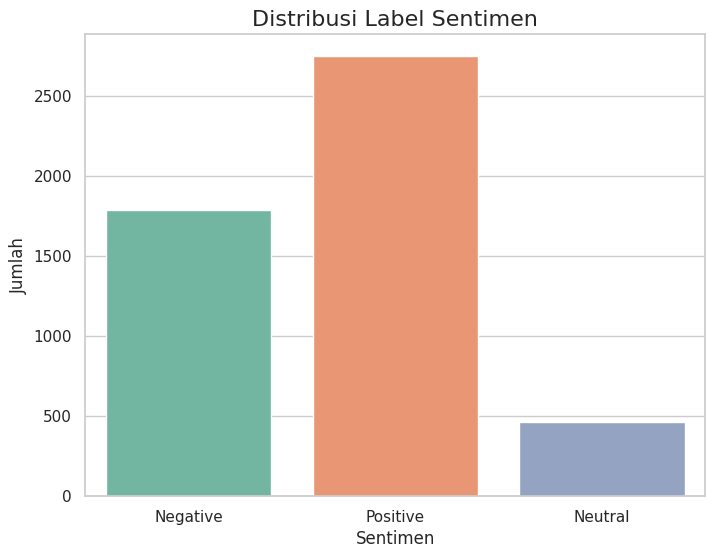

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Muat data yang sudah dilabeli
file_path = '/content/SentimentLabeledInstagram1.csv'
data = pd.read_csv(file_path)
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")
# 2. Bar Plot untuk Distribusi Label Sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data, palette='Set2')
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Misalkan data_clean adalah DataFrame Anda
file_path = '/content/TextPreprocessingInstagram (1).csv'
data_clean = pd.read_csv(file_path)
# Pastikan kolom lemmatized berisi string
data_clean['lemmatized'] = data_clean['lemmatized'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Memeriksa jumlah dokumen
print("Number of documents:", len(data_clean['lemmatized']))

# Menghitung frekuensi kata
all_words = ' '.join(data_clean['lemmatized']).split()
word_counts = Counter(all_words)
print("Most common words before TF-IDF:")
print(word_counts.most_common(10))  # Menampilkan 10 kata paling umum

# Inisialisasi TF-IDF Vectorizer dengan smoothing
max_features = 5000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1), smooth_idf=True)

# Mengubah teks menjadi representasi TF-IDF
tfidf_mat = tfidf_vectorizer.fit_transform(data_clean['lemmatized']).toarray()

# Mendapatkan IDF
IDF_vector = tfidf_vectorizer.idf_

# Menampilkan bentuk matriks TF-IDF dan IDF
print("Shape of TF-IDF matrix:", tfidf_mat.shape)
print("IDF values:", IDF_vector)

Number of documents: 5000
Most common words before TF-IDF:
[("'app',", 3292), ("'instagram',", 2160), ("'post',", 2140), ("'account',", 2083), ("'get',", 1746), ("'tri',", 1456), ("'reel',", 1400), ("'can',", 1384), ("'use',", 1350), ("'like',", 1328)]
Shape of TF-IDF matrix: (5000, 5000)
IDF values: [8.82424599 8.82424599 8.82424599 ... 8.13109881 7.90795526 6.95244381]


In [ ]:
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
import numpy as np

# Misalkan data_clean adalah DataFrame Anda
file_path = '/content/TextPreprocessingInstagram (1).csv'
data_clean = pd.read_csv(file_path)
# Pastikan kolom lemmatized berisi list of strings
data_clean['lemmatized'] = data_clean['lemmatized'].apply(lambda x: x if isinstance(x, list) else x.split())

# Memeriksa jumlah dokumen
print("Number of documents:", len(data_clean['lemmatized']))

# Menghitung frekuensi kata
all_words = [word for document in data_clean['lemmatized'] for word in document]
word_counts = Counter(all_words)
print("Most common words before TF-IDF:")
print(word_counts.most_common(10))  # Menampilkan 10 kata paling umum

# Inisialisasi Word2Vec model
model = Word2Vec(sentences=data_clean['lemmatized'], vector_size=100, window=5, min_count=5, workers=4)

# Mendapatkan vektor kata untuk setiap kata dalam kamus
word_vectors = model.wv

# Mendapatkan matriks representasi Word2Vec untuk setiap dokumen
document_vectors = []
for document in data_clean['lemmatized']:
    # document is already a list of words, so no need to split
    document_words = document  # Assign document directly as it is already a list
    # Check if any words in the document are in the vocabulary
    valid_words = [word for word in document_words if word in word_vectors]
    if valid_words:  # If there are valid words in the document
        document_vector = np.mean([word_vectors[word] for word in valid_words], axis=0)
        document_vectors.append(document_vector)
    else:  # If no words in the document are in the vocabulary
        document_vectors.append(np.zeros(model.vector_size))  # Append a vector of zeros

# Menampilkan bentuk matriks Word2Vec
print("Shape of Word2Vec matrix:", np.array(document_vectors).shape)

Number of documents: 5000
Most common words before TF-IDF:
[("'app',", 3292), ("'instagram',", 2160), ("'post',", 2140), ("'account',", 2083), ("'get',", 1746), ("'tri',", 1456), ("'reel',", 1400), ("'can',", 1384), ("'use',", 1350), ("'like',", 1328)]
Shape of Word2Vec matrix: (5000, 100)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split  # Impor yang diperlukan

# Muat data yang sudah dilabeli
file_path = '/content/SentimentLabeledInstagram1.csv'
data = pd.read_csv(file_path)
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

Klasifikasi SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd # Import pandas for data handling

# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

# Handle missing values in X_train and X_test
# Replace NaN values with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = SVC(kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.75
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.75      0.67      0.71       356
     Neutral       0.00      0.00      0.00        88
    Positive       0.74      0.91      0.82       556

    accuracy                           0.75      1000
   macro avg       0.50      0.53      0.51      1000
weighted avg       0.68      0.75      0.71      1000

Matriks Kebingungan:
[[240   0 116]
 [ 29   0  59]
 [ 49   0 507]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
X_train

,data_fixed
4227,one dm bug caus multipl issu specif can see la...
4676,get problem direct messag I unabl messag messa...
800,good app socialis make mani friend quit help a...
3671,realli use whenev perform qualiti good friend ...
4193,use tiktok inbuild video editor good take day ...
...,...
4426,dm never updat can abl repli individu text can...
466,good app follow celebr peopl share pictur etc ...
3092,good app share interest passion photo video re...
3772,realli easi use learn content wise great colla...


In [ ]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Persiapkan data untuk Word2Vec
# Misalkan X_train dan X_test adalah list dari list kata
X_train_words = [text.split() for text in X_train]
X_test_words = [text.split() for text in X_test]

# Latih model Word2Vec
model_w2v = Word2Vec(sentences=X_train_words, vector_size=100, window=5, min_count=1, workers=4)

# Fungsi untuk mendapatkan vektor rata-rata dari kalimat
def get_average_vector(words, model):
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

# Mengubah data latih dan uji menjadi vektor rata-rata
X_train_w2v = np.array([get_average_vector(text.split(), model_w2v) for text in X_train])
X_test_w2v = np.array([get_average_vector(text.split(), model_w2v) for text in X_test])

# Latih model SVC
model = SVC(kernel='rbf')
model.fit(X_train_w2v, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_w2v)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.56
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.44      0.04      0.08       356
     Neutral       0.00      0.00      0.00        88
    Positive       0.56      0.97      0.71       556

    accuracy                           0.56      1000
   macro avg       0.33      0.34      0.26      1000
weighted avg       0.47      0.56      0.42      1000

Matriks Kebingungan:
[[ 16   0 340]
 [  4   0  84]
 [ 16   0 540]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = SVC(kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.75
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.75      0.67      0.71       356
     Neutral       0.00      0.00      0.00        88
    Positive       0.74      0.91      0.82       556

    accuracy                           0.75      1000
   macro avg       0.50      0.53      0.51      1000
weighted avg       0.68      0.75      0.71      1000

Matriks Kebingungan:
[[240   0 116]
 [ 29   0  59]
 [ 49   0 507]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model naive bayes

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X and y are your data and target variables
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Handling missing values in X_train and X_test
# Replace np.nan with empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')

# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.62
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.78      0.21      0.33       346
     Neutral       0.00      0.00      0.00        97
    Positive       0.60      0.98      0.75       557

    accuracy                           0.62      1000
   macro avg       0.46      0.40      0.36      1000
weighted avg       0.61      0.62      0.53      1000

Matriks Kebingungan:
[[ 72   0 274]
 [ 11   0  86]
 [  9   0 548]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
X_train

,data_fixed
1237,use instagram past year issu new multipl post ...
3076,great piec art app good time consumpt love int...
3808,
1734,instagram buggi day can send messag properli s...
2959,instagram account unfairli suspend without gui...
...,...
4994,whatev reason instagram keep give error messag...
919,heck atleast someth well bring updat everi wee...
500,labsolut love instagram go platform connect fr...
3885,recommend could well sometim hit content see s...


In [ ]:
y_train

,Sentiment
1237,Negative
3076,Positive
3808,Neutral
1734,Positive
2959,Negative
...,...
4994,Negative
919,Negative
500,Positive
3885,Positive


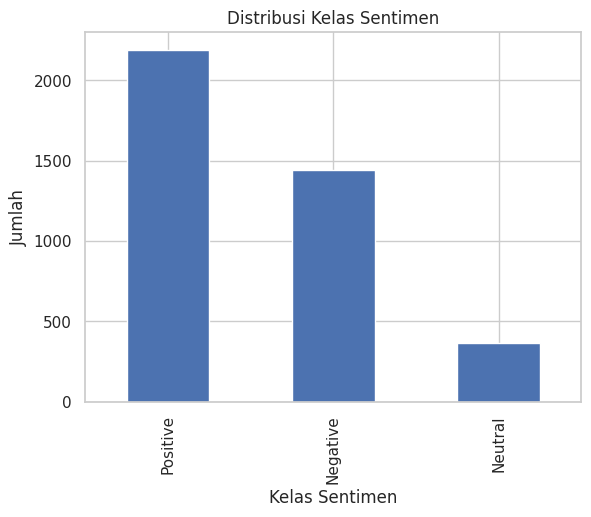

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Menghitung distribusi kelas
class_distribution = y_train.value_counts()

# Visualisasi distribusi kelas
class_distribution.plot(kind='bar')
plt.title('Distribusi Kelas Sentimen')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
!pip install imbalanced-learn scikit-learn

pakai smote

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Misalkan sorted_df adalah DataFrame Anda
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Handle missing values in 'data_fixed' column
data['data_fixed'] = data['data_fixed'].fillna('')  # Replace NaN with empty strings

# Konversi teks menjadi representasi numerik menggunakan TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Terapkan SMOTE
smote = SMOTE(sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Latih model dengan data yang telah di-resample
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

# Prediksi dan evaluasi model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Misalkan sorted_df adalah DataFrame Anda
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Hapus kelas netral
y = y[y != 'Neutral']
X = X[y.index]  # Pastikan X tetap sinkron dengan y

# Konversi teks menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Latih model SVC
model_svc = SVC(kernel='linear')  # Anda bisa mencoba kernel yang berbeda
model_svc.fit(X_train, y_train)

# Prediksi dan evaluasi model
y_pred_svc = model_svc.predict(X_test)
print("Hasil klasifikasi menggunakan SVC:")
print(classification_report(y_test, y_pred_svc))

Hasil klasifikasi menggunakan SVC:
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83       342
    Positive       0.89      0.90      0.90       566

    accuracy                           0.87       908
   macro avg       0.86      0.86      0.86       908
weighted avg       0.87      0.87      0.87       908



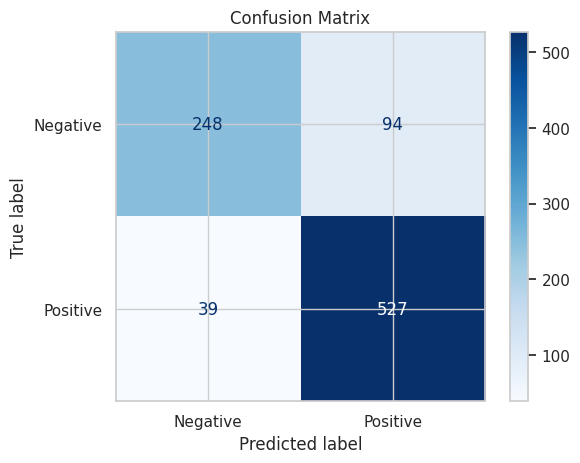

Hasil klasifikasi menggunakan SVC:
              precision    recall  f1-score   support

    Negative       0.86      0.73      0.79       342
    Positive       0.85      0.93      0.89       566

    accuracy                           0.85       908
   macro avg       0.86      0.83      0.84       908
weighted avg       0.85      0.85      0.85       908

Akurasi: 0.85


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt # Import matplotlib for plotting
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay


# Misalkan sorted_df adalah DataFrame Anda
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Hapus kelas netral
y = y[y != 'Neutral']
X = X[y.index]  # Pastikan X tetap sinkron dengan y

# Konversi teks menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Latih model SVC
model_svc = SVC(kernel='rbf')  # Anda bisa mencoba kernel yang berbeda
model_svc.fit(X_train, y_train)

# Prediksi dan evaluasi model
y_pred_svc = model_svc.predict(X_test)

# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svc.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Hitung akurasi
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Hasil klasifikasi menggunakan SVC:")
print(classification_report(y_test, y_pred_svc))
print(f"Akurasi: {accuracy_svc:.2f}")

Klasifikasi SVM kernel linier

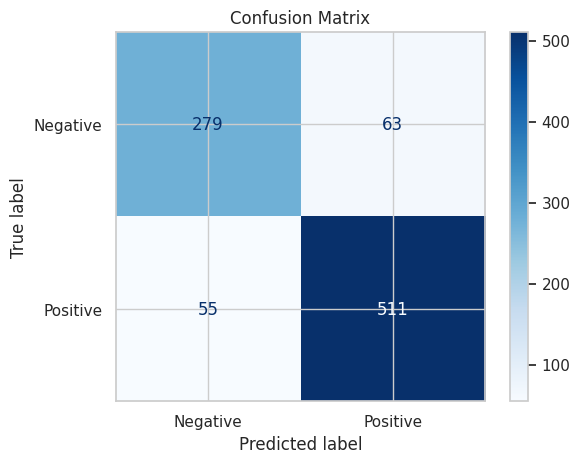

Hasil klasifikasi menggunakan SVC:
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83       342
    Positive       0.89      0.90      0.90       566

    accuracy                           0.87       908
   macro avg       0.86      0.86      0.86       908
weighted avg       0.87      0.87      0.87       908

Akurasi: 0.87


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Misalkan sorted_df adalah DataFrame Anda
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Hapus kelas netral
y = y[y != 'Neutral']
X = X[y.index]  # Pastikan X tetap sinkron dengan y

# Konversi teks menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Latih model SVC
model_svc = SVC(kernel='linear')  # Anda bisa mencoba kernel yang berbeda
model_svc.fit(X_train, y_train)

# Prediksi dan evaluasi model
y_pred_svc = model_svc.predict(X_test)

# Misalkan y_test adalah label sebenarnya dan y_pred adalah prediksi dari model SVC
cm = confusion_matrix(y_test, y_pred_svc)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svc.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Hitung akurasi
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Hasil klasifikasi menggunakan SVC:")
print(classification_report(y_test, y_pred_svc))
print(f"Akurasi: {accuracy_svc:.2f}")


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Parameter grid untuk SVM
param_grid = {'C': [1, 10, 100], 'class_weight': [None, 'balanced']}

# Model SVM dengan kernel linear
svc = SVC(kernel='linear')

# GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Hasil terbaik
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Prediksi dengan model terbaik
y_pred = best_model.predict(X_test)

# Evaluasi hasil
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'C': 10, 'class_weight': 'balanced'}
Confusion Matrix:
[[289  53]
 [ 56 510]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.85      0.84       342
    Positive       0.91      0.90      0.90       566

    accuracy                           0.88       908
   macro avg       0.87      0.87      0.87       908
weighted avg       0.88      0.88      0.88       908



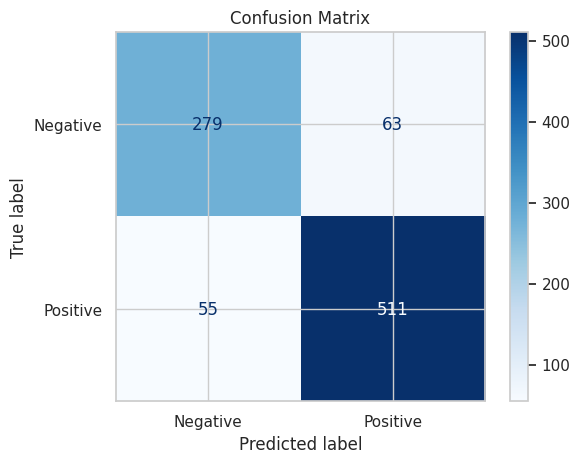

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Misalkan y_test adalah label sebenarnya dan y_pred adalah prediksi dari model SVC
cm = confusion_matrix(y_test, y_pred_svc)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svc.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


ValueError: y should be a 1d array, got an array of shape (200, 200) instead.

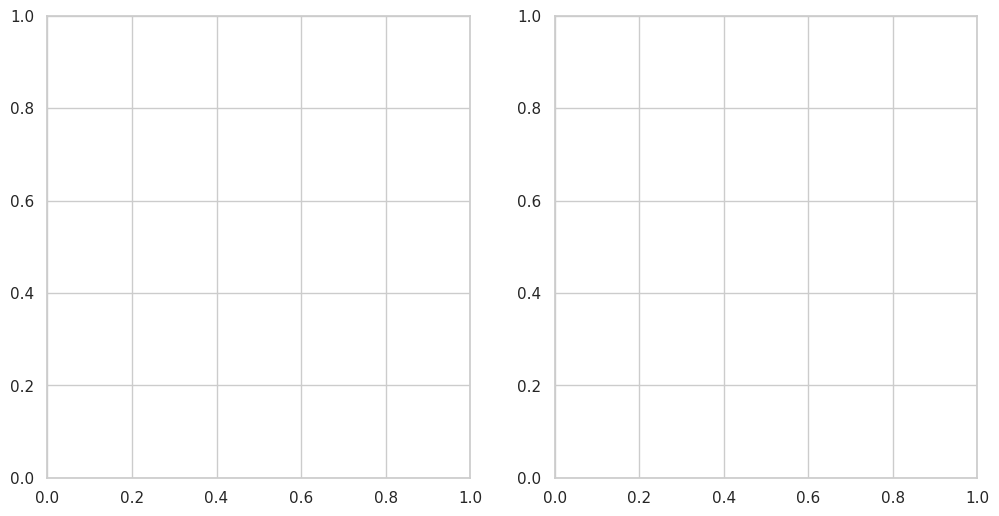

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# ... (Your existing code up to model training)...

# Convert y_train and y_test to numerical labels using LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train) # Fit LabelEncoder on y_train and transform it
y_test_encoded = le.transform(y_test) # Transform y_test using the same LabelEncoder

# Model SVM with kernel RBF and Linear, using encoded labels for training
kernels = ['linear', 'rbf']
models = {kernel: SVC(kernel=kernel).fit(X_train_pca, y_train_encoded) for kernel in kernels} # Train models with encoded labels

# Visualisasi data and decision boundary
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (kernel, model) in zip(axes, models.items()):
    # Buat grid untuk prediksi
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    # Prediksi area pada grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Convert Z back to original labels for visualization
    Z = le.inverse_transform(Z) # Inverse transform to get original labels for plotting

    # Plot decision boundary
    # Use a ListedColormap for discrete color mapping
    from matplotlib.colors import ListedColormap # Import ListedColormap
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']) # Define colormap for light colors
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF']) # Define colormap for bold colors

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=cmap_light) # Use cmap_light for contourf
    ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap=cmap_bold, edgecolors='k') # Use cmap_bold for scatter plot
    ax.set_title(f"SVM with {kernel} kernel")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Misalkan sorted_df adalah DataFrame Anda
# Definisikan fitur dan label
X = data['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Hapus kelas netral
y = y[y != 'Neutral']
X = X[y.index]  # Pastikan X tetap sinkron dengan y

# Konversi teks menjadi representasi numerik menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Latih model Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

# Prediksi dan evaluasi model
y_pred_nb = model_nb.predict(X_test)

# Hitung akurasi
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Hasil klasifikasi menggunakan Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
print(f"Akurasi: {accuracy_nb:.2f}")

Hasil klasifikasi menggunakan Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.90      0.26      0.40       342
    Positive       0.69      0.98      0.81       566

    accuracy                           0.71       908
   macro avg       0.79      0.62      0.61       908
weighted avg       0.77      0.71      0.66       908

Akurasi: 0.71


SAMPE SINI POKONYA

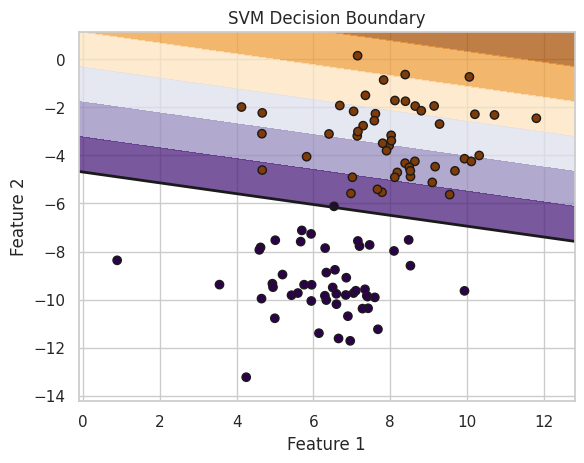

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

# Step 1: Generate a simple 2D dataset
X, y = make_blobs(n_samples=100, centers=2, random_state=6, cluster_std=1.5)

# Step 2: Fit an SVM model
model = SVC(kernel='linear', C=1.0)
model.fit(X, y)

# Step 3: Plot decision boundary
def plot_decision_boundary(X, y, model):
    # Create a grid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Predict the function value for the grid
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), alpha=0.75, cmap=plt.cm.PuOr)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')  # Hyperplane
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.PuOr, edgecolors='k')  # Data points
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Call the function to plot
plot_decision_boundary(X, y, model)


In [ ]:
# Import StemmerFactory from Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # This line imports the missing StemmerFactory


In [ ]:
# Membuat objek stemmer Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}
for document in data_clean['stopword_removal']:
  for term in document:
    if term not in term_dict:
      term_dict[term] = ' '

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)

def get_stemmed_term(document):
  return [term_dict[term] for term in document]

data_clean['stemming'] = data_clean['stopword_removal'].apply(lambda x: get_stemmed_term(x))

<ipython-input-26-681d9c7edcb8>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['stemming'] = data_clean['stopword_removal'].apply(lambda x: get_stemmed_term(x))


In [ ]:
data_clean.head(10)

,score,content,case_folding,tokenizing,normalized,stopword_removal,stemming
0,1,"Mudah refresh terus, foto yg dilihat langsung ...",mudah refresh terus foto yg dilihat langsung h...,"[mudah, refresh, terus, foto, yg, dilihat, lan...","[mudah, segarkan, terus, foto, yang, dilihat, ...","[mudah, segarkan, foto, langsung, hilang, keba...","[mudah, segar, foto, langsung, hilang, bawah, ..."
1,1,Setelah update malah banyak bug. Di story tuli...,setelah update malah banyak bug di story tulis...,"[setelah, update, malah, banyak, bug, di, stor...","[setelah, update, malah, banyak, kesalahan, di...","[update, kesalahan, cerita, teks, nya, lagu, t...","[update, salah, cerita, teks, nya, lagu, temu,..."
2,1,Banyak bug nya dan sampe sekarang belum diperb...,banyak bug nya dan sampe sekarang belum diperb...,"[banyak, bug, nya, dan, sampe, sekarang, belum...","[banyak, kesalahan, nya, dan, sampai, sekarang...","[kesalahan, nya, diperbaiki, report, customer ...","[salah, nya, baik, report, customer service, n..."
3,2,"sekarang ko aneh bangett, mau upload story mut...",sekarang ko aneh bangett mau upload story mute...,"[sekarang, ko, aneh, bangett, mau, upload, sto...","[sekarang, ko, aneh, bangett, mau, unggah, cer...","[ko, aneh, bangett, unggah, cerita, muter, jar...","[ko, aneh, bangett, unggah, cerita, muter, jar..."
4,1,"Tolong buat pihak instagram, keluhan pengguna ...",tolong buat pihak instagram keluhan pengguna d...,"[tolong, buat, pihak, instagram, keluhan, peng...","[tolong, buat, pihak, instagram, keluhan, peng...","[instagram, keluhan, pengguna, tanggapin, tida...","[instagram, keluh, guna, tanggapin, tidak usah..."
5,1,ini Instagram kenapa ya???? setiap buat sorota...,ini instagram kenapa ya setiap buat sorotan ba...,"[ini, instagram, kenapa, ya, setiap, buat, sor...","[ini, instagram, kenapa, ya, setiap, buat, sor...","[instagram, sorotan, plus, sampul, nya, loadin...","[instagram, sorot, plus, sampul, nya, loading,..."
6,5,salah satu aplikasi media sosial favorit aku n...,salah satu aplikasi media sosial favorit aku n...,"[salah, satu, aplikasi, media, sosial, favorit...","[salah, satu, aplikasi, media, sosial, favorit...","[salah, aplikasi, media, sosial, favorit, apli...","[salah, aplikasi, media, sosial, favorit, apli..."
7,1,"banyak update banyak juga bug, saya udah follo...",banyak update banyak juga bug saya udah follow...,"[banyak, update, banyak, juga, bug, saya, udah...","[banyak, update, banyak, juga, kesalahan, saya...","[update, kesalahan, ikuti, teman, le, hentikan...","[update, salah, ikut, teman, le, henti, ulang,..."
8,4,"Halo, Instagram! Aku mau sampaikan keinginanku...",halo instagram aku mau sampaikan keinginanku d...,"[halo, instagram, aku, mau, sampaikan, keingin...","[halo, instagram, saya, mau, sampaikan, keingi...","[halo, instagram, keinginanku, aplikasi, insta...","[halo, instagram, ingin, aplikasi, instagram, ..."
9,2,"Makin sini makin banyak bug aplikasi ini, Mau ...",makin sini makin banyak bug aplikasi ini mau l...,"[makin, sini, makin, banyak, bug, aplikasi, in...","[makin, sini, makin, banyak, kesalahan, aplika...","[kesalahan, aplikasi, liat, cerita, loadingnya...","[salah, aplikasi, liat, cerita, loadingnya, si..."


In [ ]:
data_clean['text'] = data_clean['stemming']

# menghapus kolom "stemming" agar hanya kolom "text" yang tersisa:
#data_clean = data_clean.drop(columns=['stemming'])

# Menampilkan DataFrame yang sudah diperbarui
data_clean.head(10)

<ipython-input-28-dc791aa1cc39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text'] = data_clean['stemming']


,score,content,case_folding,tokenizing,normalized,stopword_removal,stemming,text
0,1,"Mudah refresh terus, foto yg dilihat langsung ...",mudah refresh terus foto yg dilihat langsung h...,"[mudah, refresh, terus, foto, yg, dilihat, lan...","[mudah, segarkan, terus, foto, yang, dilihat, ...","[mudah, segarkan, foto, langsung, hilang, keba...","[mudah, segar, foto, langsung, hilang, bawah, ...","[mudah, segar, foto, langsung, hilang, bawah, ..."
1,1,Setelah update malah banyak bug. Di story tuli...,setelah update malah banyak bug di story tulis...,"[setelah, update, malah, banyak, bug, di, stor...","[setelah, update, malah, banyak, kesalahan, di...","[update, kesalahan, cerita, teks, nya, lagu, t...","[update, salah, cerita, teks, nya, lagu, temu,...","[update, salah, cerita, teks, nya, lagu, temu,..."
2,1,Banyak bug nya dan sampe sekarang belum diperb...,banyak bug nya dan sampe sekarang belum diperb...,"[banyak, bug, nya, dan, sampe, sekarang, belum...","[banyak, kesalahan, nya, dan, sampai, sekarang...","[kesalahan, nya, diperbaiki, report, customer ...","[salah, nya, baik, report, customer service, n...","[salah, nya, baik, report, customer service, n..."
3,2,"sekarang ko aneh bangett, mau upload story mut...",sekarang ko aneh bangett mau upload story mute...,"[sekarang, ko, aneh, bangett, mau, upload, sto...","[sekarang, ko, aneh, bangett, mau, unggah, cer...","[ko, aneh, bangett, unggah, cerita, muter, jar...","[ko, aneh, bangett, unggah, cerita, muter, jar...","[ko, aneh, bangett, unggah, cerita, muter, jar..."
4,1,"Tolong buat pihak instagram, keluhan pengguna ...",tolong buat pihak instagram keluhan pengguna d...,"[tolong, buat, pihak, instagram, keluhan, peng...","[tolong, buat, pihak, instagram, keluhan, peng...","[instagram, keluhan, pengguna, tanggapin, tida...","[instagram, keluh, guna, tanggapin, tidak usah...","[instagram, keluh, guna, tanggapin, tidak usah..."
5,1,ini Instagram kenapa ya???? setiap buat sorota...,ini instagram kenapa ya setiap buat sorotan ba...,"[ini, instagram, kenapa, ya, setiap, buat, sor...","[ini, instagram, kenapa, ya, setiap, buat, sor...","[instagram, sorotan, plus, sampul, nya, loadin...","[instagram, sorot, plus, sampul, nya, loading,...","[instagram, sorot, plus, sampul, nya, loading,..."
6,5,salah satu aplikasi media sosial favorit aku n...,salah satu aplikasi media sosial favorit aku n...,"[salah, satu, aplikasi, media, sosial, favorit...","[salah, satu, aplikasi, media, sosial, favorit...","[salah, aplikasi, media, sosial, favorit, apli...","[salah, aplikasi, media, sosial, favorit, apli...","[salah, aplikasi, media, sosial, favorit, apli..."
7,1,"banyak update banyak juga bug, saya udah follo...",banyak update banyak juga bug saya udah follow...,"[banyak, update, banyak, juga, bug, saya, udah...","[banyak, update, banyak, juga, kesalahan, saya...","[update, kesalahan, ikuti, teman, le, hentikan...","[update, salah, ikut, teman, le, henti, ulang,...","[update, salah, ikut, teman, le, henti, ulang,..."
8,4,"Halo, Instagram! Aku mau sampaikan keinginanku...",halo instagram aku mau sampaikan keinginanku d...,"[halo, instagram, aku, mau, sampaikan, keingin...","[halo, instagram, saya, mau, sampaikan, keingi...","[halo, instagram, keinginanku, aplikasi, insta...","[halo, instagram, ingin, aplikasi, instagram, ...","[halo, instagram, ingin, aplikasi, instagram, ..."
9,2,"Makin sini makin banyak bug aplikasi ini, Mau ...",makin sini makin banyak bug aplikasi ini mau l...,"[makin, sini, makin, banyak, bug, aplikasi, in...","[makin, sini, makin, banyak, kesalahan, aplika...","[kesalahan, aplikasi, liat, cerita, loadingnya...","[salah, aplikasi, liat, cerita, loadingnya, si...","[salah, aplikasi, liat, cerita, loadingnya, si..."


In [ ]:
sorted_df = data_clean[['score', 'text']]
sorted_df.head()

,score,text
0,1,"[mudah, segar, foto, langsung, hilang, bawah, ..."
1,1,"[update, salah, cerita, teks, nya, lagu, temu,..."
2,1,"[salah, nya, baik, report, customer service, n..."
3,2,"[ko, aneh, bangett, unggah, cerita, muter, jar..."
4,1,"[instagram, keluh, guna, tanggapin, tidak usah..."


In [ ]:
#menyatukan ulasan perkata menjadi satu kalimat
sorted_df['text'] = sorted_df['text'].apply(lambda x: ' '.join(x))

<ipython-input-30-7667cf328bee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_df['text'] = sorted_df['text'].apply(lambda x: ' '.join(x))


In [ ]:
data_clean.to_csv('TextPreprocessingInstagram.csv', index = False)

In [ ]:
sorted_df.to_csv('TextPreprocessingInstagram2.csv', index = False)

Translator

In [ ]:
!pip install googletrans==3.1.0a0
from googletrans import Translator

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=8ee406146d5a4aa72d5fdc1143d48c2bb31905ea83b25f8b40d959052b366359
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      Succe

In [ ]:
import pandas as pd
import googletrans
from googletrans import Translator

In [ ]:
sorted_df = pd.read_csv('TextPreprocessingInstagram2.csv')
sorted_df.head(10)

,score,text
0,1,mudah segar foto langsung hilang bawah cari su...
1,1,update salah cerita teks nya lagu temu cerita ...
2,1,salah nya baik report customer service nya mas...
3,2,ko aneh bangett unggah cerita muter jaring par...
4,1,instagram keluh guna tanggapin tidak usah angg...
5,1,instagram sorot plus sampul nya loading nya ba...
6,5,salah aplikasi media sosial favorit aplikasi b...
7,1,update salah ikut teman le henti ulang ulang k...
8,4,halo instagram ingin aplikasi instagram lagu s...
9,2,salah aplikasi liat cerita loadingnya sinyal b...


In [ ]:
# Inisialisasi Translator
translator = Translator()

# Membaca DataFrame
sorted_df = pd.read_csv('TextPreprocessingInstagram2.csv')

# Menerjemahkan kolom 'text'
translations = {}
for text in sorted_df['text']:
    if text not in translations:
        # Menerjemahkan teks ke bahasa Inggris (atau bahasa target yang diinginkan)
        translated_text = translator.translate(text, dest='en').text
        translations[text] = translated_text

# Mengganti teks asli dengan terjemahan
sorted_df['text'] = sorted_df['text'].replace(translations)


In [ ]:
sorted_df.replace(translations, inplace=True)
sorted_df.head(10)

,score,text
0,1,"easy, fresh, photos immediately disappear at t..."
1,1,"the update is wrong, the text of the story, th..."
2,1,"it's wrong, it's good, report the customer ser..."
3,2,How come it's so strange to upload a story tha...
4,1,"Instagram complains to respond, don't worry, I..."
5,1,instagram spotlight plus the cover is loading ...
6,5,one of your favorite social media applications...
7,1,wrong update follow friend le stop restarting ...
8,4,hello instagram want the instagram app story s...
9,2,"wrong application, see the story loading, the ..."


In [ ]:
sorted_df.to_csv('Translate.csv', index = False)

In [ ]:
import pandas as pd
def load_data():
  data = pd.read_csv('Translate.csv')
  return data

In [ ]:
text_df = load_data()
text_df.head()

,score,text
0,1,"easy, fresh, photos immediately disappear at t..."
1,1,"the update is wrong, the text of the story, th..."
2,1,"it's wrong, it's good, report the customer ser..."
3,2,How come it's so strange to upload a story tha...
4,1,"Instagram complains to respond, don't worry, I..."


#analisis sentimen vader

In [ ]:
#lexocion based
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
text_df['text'] = text_df['text'].astype(str)

analyser = SentimentIntensityAnalyzer()
scores = [analyser.polarity_scores(x) for x in text_df['text']]
print(scores)
text_df['Compound_score'] = [x['compound'] for x in scores]

[{'neg': 0.214, 'neu': 0.607, 'pos': 0.18, 'compound': -0.1027}, {'neg': 0.101, 'neu': 0.712, 'pos': 0.188, 'compound': 0.6124}, {'neg': 0.152, 'neu': 0.7, 'pos': 0.149, 'compound': -0.0516}, {'neg': 0.201, 'neu': 0.705, 'pos': 0.094, 'compound': -0.5658}, {'neg': 0.179, 'neu': 0.642, 'pos': 0.179, 'compound': 0.0015}, {'neg': 0.237, 'neu': 0.703, 'pos': 0.06, 'compound': -0.7239}, {'neg': 0.153, 'neu': 0.463, 'pos': 0.384, 'compound': 0.8176}, {'neg': 0.317, 'neu': 0.556, 'pos': 0.127, 'compound': -0.5859}, {'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'compound': 0.7351}, {'neg': 0.054, 'neu': 0.875, 'pos': 0.07, 'compound': 0.1531}, {'neg': 0.071, 'neu': 0.89, 'pos': 0.04, 'compound': -0.25}, {'neg': 0.077, 'neu': 0.634, 'pos': 0.289, 'compound': 0.7184}, {'neg': 0.15, 'neu': 0.766, 'pos': 0.083, 'compound': -0.3328}, {'neg': 0.422, 'neu': 0.355, 'pos': 0.223, 'compound': -0.8643}, {'neg': 0.093, 'neu': 0.848, 'pos': 0.059, 'compound': -0.0772}, {'neg': 0.182, 'neu': 0.486, 'pos': 0.331,

In [ ]:
text_df.head()

,score,text,Compound_score
0,1,"easy, fresh, photos immediately disappear at t...",-0.1027
1,1,"the update is wrong, the text of the story, th...",0.6124
2,1,"it's wrong, it's good, report the customer ser...",-0.0516
3,2,How come it's so strange to upload a story tha...,-0.5658
4,1,"Instagram complains to respond, don't worry, I...",0.0015


In [ ]:
text_df.loc[text_df['Compound_score'] > 0.05, 'Sentiment'] = 'Positive'
text_df.loc[text_df['Compound_score'] < -0.05, 'Sentiment'] = 'Negative'
text_df.loc[(text_df['Compound_score'] >= -0.05) & (text_df['Compound_score'] <= 0.05), 'Sentiment'] = 'Neutral'
text_df.head()

,score,text,Compound_score,Sentiment
0,1,"easy, fresh, photos immediately disappear at t...",-0.1027,Negative
1,1,"the update is wrong, the text of the story, th...",0.6124,Positive
2,1,"it's wrong, it's good, report the customer ser...",-0.0516,Negative
3,2,How come it's so strange to upload a story tha...,-0.5658,Negative
4,1,"Instagram complains to respond, don't worry, I...",0.0015,Neutral


In [ ]:
text_df.to_csv('SentimentLabeledInstagram1.csv', index = False)

In [ ]:
#mengembalikan ke bahasa indonesia
translator = Translator()
translations = {}
data['review'] = data['text'].apply(translator.translate, src='en', dest='id').apply(getattr, args=('text',))
data

visualisasi sebaran data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Muat data yang sudah dilabeli
file_path = '/content/SentimentLabeledInstagram1.csv'
data = pd.read_csv(file_path)
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")
# 2. Bar Plot untuk Distribusi Label Sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data, palette='Set2')
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

In [ ]:
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")

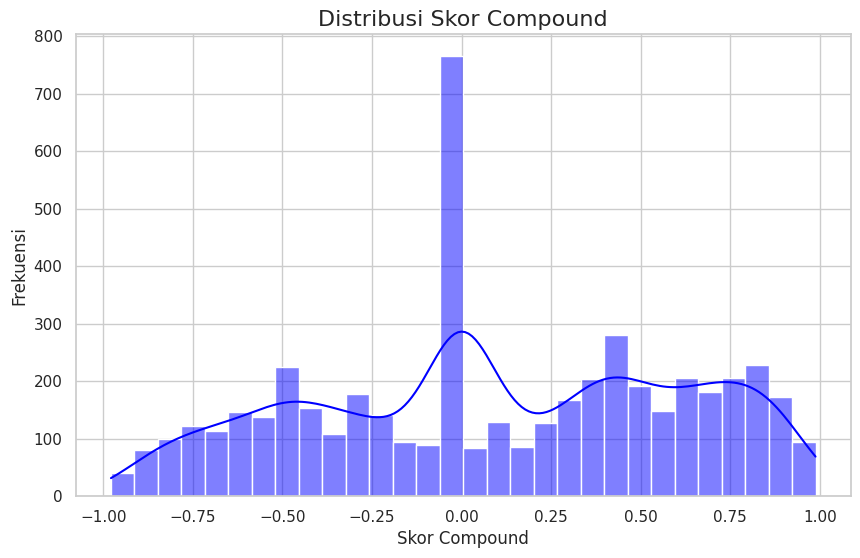

In [ ]:
# 1. Histogram untuk distribusi Skor Compound
plt.figure(figsize=(10, 6))
sns.histplot(data['Compound_score'], bins=30, kde=True, color='blue')
plt.title('Distribusi Skor Compound', fontsize=16)
plt.xlabel('Skor Compound', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()

<ipython-input-51-a445c1596453>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=data, palette='Set2')


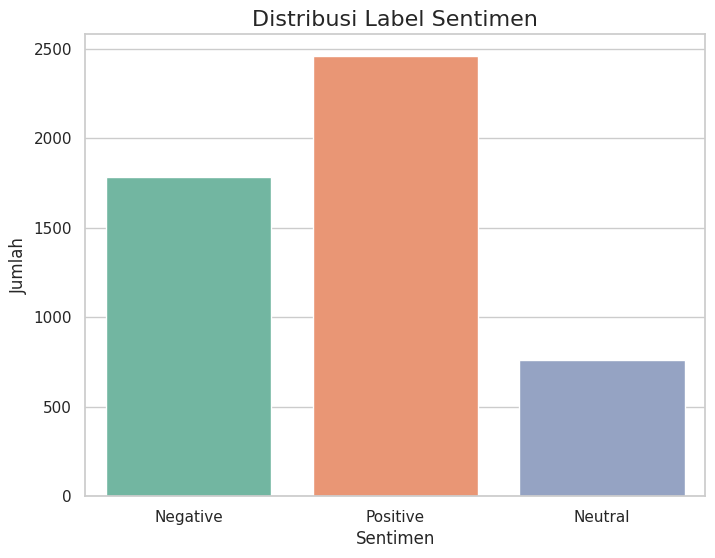

In [ ]:
# 2. Bar Plot untuk Distribusi Label Sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data, palette='Set2')
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

Pembobotan TF-IDF

In [ ]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

# Memeriksa jumlah dokumen
print("Number of documents:", len(data_clean['text']))

# Menghitung frekuensi kata
all_words = ' '.join([str(item) for item in data_clean['text']]).split()
word_counts = Counter(all_words)
print("Most common words before TF-IDF:")
print(word_counts.most_common(10))  # Menampilkan 10 kata paling umum

# Inisialisasi TF-IDF Vectorizer dengan smoothing
max_features = 5000
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 1), smooth_idf=True)

# Mengubah teks menjadi representasi TF-IDF
tfidf_mat = tfidf_vectorizer.fit_transform(data_clean['text'].astype(str)).toarray()

# Mendapatkan IDF
IDF_vector = tfidf_vectorizer.idf_

# Menampilkan bentuk matriks TF-IDF dan IDF
print("Shape of TF-IDF matrix:", tfidf_mat.shape)
print("IDF values:", IDF_vector)

Number of documents: 5000
Most common words before TF-IDF:
[("'instagram',", 2488), ("'nya',", 1527), ("'akun',", 1470), ("'fungsi',", 1198), ("'salah',", 944), ("'cerita',", 915), ("'aplikasi',", 884), ("'video',", 732), ("'update',", 731), ("'unggah',", 724)]
Shape of TF-IDF matrix: (5000, 5000)
IDF values: [8.82424599 8.82424599 8.82424599 ... 8.82424599 8.82424599 7.57148302]


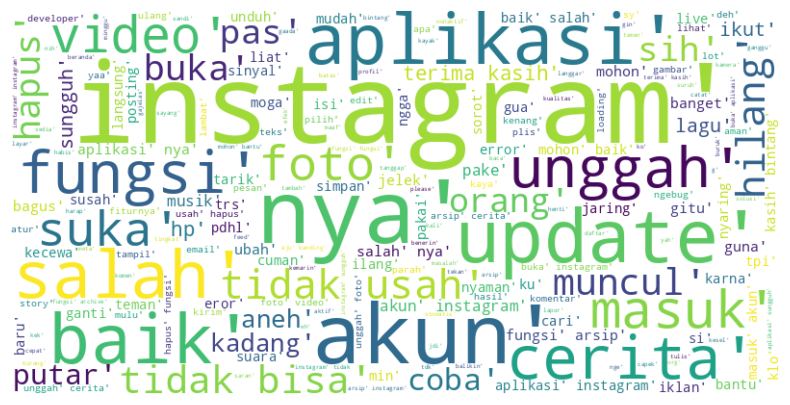

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Menggabungkan semua teks untuk visualisasi
all_text = ' '.join([str(item) for item in data_clean['text']])

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menyembunyikan sumbu
plt.show()

klasifikasi SVC

In [ ]:
# Muat data yang sudah dilabeli
file_path = '/content/SentimentLabeledInstagram1.csv'
data = pd.read_csv(file_path)
data_clean['data_fixed'] = data_clean['text'].apply(lambda tokens: ' '.join(tokens))
# Definisikan fitur dan label
X = data_clean['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [ ]:
data_clean['data_fixed'] = data_clean['text'].apply(lambda tokens: ' '.join(tokens))

<ipython-input-61-f36cba0b007c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['data_fixed'] = data_clean['text'].apply(lambda tokens: ' '.join(tokens))


In [ ]:
# Definisikan fitur dan label
X = data_clean['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = SVC(kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.72
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.73      0.72      0.73       352
     Neutral       0.64      0.10      0.18       136
    Positive       0.71      0.88      0.79       512

    accuracy                           0.72      1000
   macro avg       0.69      0.57      0.56      1000
weighted avg       0.71      0.72      0.68      1000

Matriks Kebingungan:
[[255   2  95]
 [ 37  14  85]
 [ 58   6 448]]


TAMBAHAN SETELAH BIMIBINGAN
---MENGGUNAKAN WORD2VEC---

In [ ]:
#mengunakan gensim
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
import numpy as np

# Memeriksa jumlah dokumen
print("Number of documents:", len(data_clean['text']))

# Menghitung frekuensi kata
all_words = ' '.join([str(item) for item in data_clean['text']]).split()
word_counts = Counter(all_words)
print("Most common words before TF-IDF:")
print(word_counts.most_common(10))  # Menampilkan 10 kata paling umum

# Inisialisasi Word2Vec model
model = Word2Vec(sentences=data_clean['text'], vector_size=100, window=5, min_count=5, workers=4)

# Mendapatkan vektor kata untuk setiap kata dalam kamus
word_vectors = model.wv

# Mendapatkan matriks representasi Word2Vec untuk setiap dokumen
document_vectors = []
for document in data_clean['text']:
    # document is already a list of words, so no need to split
    #document_words = document.split()
    document_words = document # Assign document directly as it is already a list
    # Check if any words in the document are in the vocabulary
    valid_words = [word for word in document_words if word in word_vectors]
    if valid_words:  # If there are valid words in the document
        document_vector = np.mean([word_vectors[word] for word in valid_words], axis=0)
        document_vectors.append(document_vector)
    else:  # If no words in the document are in the vocabulary
        document_vectors.append(np.zeros(model.vector_size)) # Append a vector of zeros


# Menampilkan bentuk matriks Word2Vec
print("Shape of Word2Vec matrix:", np.array(document_vectors).shape)

Number of documents: 5000
Most common words before TF-IDF:
[("'instagram',", 2488), ("'nya',", 1527), ("'akun',", 1470), ("'fungsi',", 1198), ("'salah',", 944), ("'cerita',", 915), ("'aplikasi',", 884), ("'video',", 732), ("'update',", 731), ("'unggah',", 724)]
Shape of Word2Vec matrix: (5000, 100)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definisikan fitur dan label
X = data_clean['data_fixed']  # Kolom teks yang sudah diterjemahkan
y = data['Sentiment']  # Kolom label yang dihasilkan dari VADER

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = SVC(kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.72
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.76      0.70      0.73       336
     Neutral       0.71      0.14      0.24       142
    Positive       0.71      0.90      0.79       522

    accuracy                           0.72      1000
   macro avg       0.73      0.58      0.58      1000
weighted avg       0.73      0.72      0.69      1000

Matriks Kebingungan:
[[234   2 100]
 [ 29  20  93]
 [ 46   6 470]]


Klasifikasi naive bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.65
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.68      0.54      0.60       352
     Neutral       0.00      0.00      0.00       136
    Positive       0.64      0.90      0.75       512

    accuracy                           0.65      1000
   macro avg       0.44      0.48      0.45      1000
weighted avg       0.57      0.65      0.59      1000

Matriks Kebingungan:
[[191   0 161]
 [ 36   0 100]
 [ 53   0 459]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
data_clean.head()

,score,content,case_folding,tokenizing,normalized,stopword_removal,stemming,text,data_fixed
0,1,"Mudah refresh terus, foto yg dilihat langsung ...",mudah refresh terus foto yg dilihat langsung h...,"[mudah, refresh, terus, foto, yg, dilihat, lan...","[mudah, segarkan, terus, foto, yang, dilihat, ...","[mudah, segarkan, foto, langsung, hilang, keba...","[mudah, segar, foto, langsung, hilang, bawah, ...","[mudah, segar, foto, langsung, hilang, bawah, ...",mudah segar foto langsung hilang bawah cari su...
1,1,Setelah update malah banyak bug. Di story tuli...,setelah update malah banyak bug di story tulis...,"[setelah, update, malah, banyak, bug, di, stor...","[setelah, update, malah, banyak, kesalahan, di...","[update, kesalahan, cerita, teks, nya, lagu, t...","[update, salah, cerita, teks, nya, lagu, temu,...","[update, salah, cerita, teks, nya, lagu, temu,...",update salah cerita teks nya lagu temu cerita ...
2,1,Banyak bug nya dan sampe sekarang belum diperb...,banyak bug nya dan sampe sekarang belum diperb...,"[banyak, bug, nya, dan, sampe, sekarang, belum...","[banyak, kesalahan, nya, dan, sampai, sekarang...","[kesalahan, nya, diperbaiki, report, customer ...","[salah, nya, baik, report, customer service, n...","[salah, nya, baik, report, customer service, n...",salah nya baik report customer service nya mas...
3,2,"sekarang ko aneh bangett, mau upload story mut...",sekarang ko aneh bangett mau upload story mute...,"[sekarang, ko, aneh, bangett, mau, upload, sto...","[sekarang, ko, aneh, bangett, mau, unggah, cer...","[ko, aneh, bangett, unggah, cerita, muter, jar...","[ko, aneh, bangett, unggah, cerita, muter, jar...","[ko, aneh, bangett, unggah, cerita, muter, jar...",ko aneh bangett unggah cerita muter jaring par...
4,1,"Tolong buat pihak instagram, keluhan pengguna ...",tolong buat pihak instagram keluhan pengguna d...,"[tolong, buat, pihak, instagram, keluhan, peng...","[tolong, buat, pihak, instagram, keluhan, peng...","[instagram, keluhan, pengguna, tanggapin, tida...","[instagram, keluh, guna, tanggapin, tidak usah...","[instagram, keluh, guna, tanggapin, tidak usah...",instagram keluh guna tanggapin tidak usah angg...


In [ ]:
data_clean['data_fixed'] = data_clean['text'].apply(lambda tokens: ' '.join(tokens))

<ipython-input-60-f36cba0b007c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['data_fixed'] = data_clean['text'].apply(lambda tokens: ' '.join(tokens))


In [ ]:
y_pred

array(['Positive', 'Negative', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Positive', 'Negative', 'Positive', 'Positi

In [ ]:
from sklearn.svm import SVC
# Transformasi data menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Latih model Naive Bayes
model = SVC(kernel='rbf')
model.fit(X_train_tfidf, y_train)

# Prediksi dengan data uji
y_pred = model.predict(X_test_tfidf)

# Evaluasi kinerja model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi: {accuracy:.2f}')

print('Laporan Klasifikasi:')
print(classification_report(y_test, y_pred))

print('Matriks Kebingungan:')
print(confusion_matrix(y_test, y_pred))

Akurasi: 0.67
Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.74      0.63      0.68       377
     Neutral       0.77      0.13      0.22       157
    Positive       0.63      0.89      0.74       466

    accuracy                           0.67      1000
   macro avg       0.71      0.55      0.54      1000
weighted avg       0.69      0.67      0.63      1000

Matriks Kebingungan:
[[236   3 138]
 [ 35  20 102]
 [ 50   3 413]]


Tambahan setelah bimbingan

In [ ]:
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
import numpy as np

# Memeriksa jumlah dokumen
print("Number of documents:", len(data_clean['text']))

# Menghitung frekuensi kata
all_words = ' '.join([str(item) for item in data_clean['text']]).split()
word_counts = Counter(all_words)
print("Most common words before TF-IDF:")
print(word_counts.most_common(10))  # Menampilkan 10 kata paling umum

# Inisialisasi Word2Vec model
model = Word2Vec(sentences=data_clean['text'], vector_size=100, window=5, min_count=5, workers=4)

# Mendapatkan vektor kata untuk setiap kata dalam kamus
word_vectors = model.wv

# Mendapatkan matriks representasi Word2Vec untuk setiap dokumen
document_vectors = []
for document in data_clean['text']:
    # document is already a list of words, so no need to split
    #document_words = document.split()
    document_words = document # Assign document directly as it is already a list
    # Check if any words in the document are in the vocabulary
    valid_words = [word for word in document_words if word in word_vectors]
    if valid_words:  # If there are valid words in the document
        document_vector = np.mean([word_vectors[word] for word in valid_words], axis=0)
        document_vectors.append(document_vector)
    else:  # If no words in the document are in the vocabulary
        document_vectors.append(np.zeros(model.vector_size)) # Append a vector of zeros


# Menampilkan bentuk matriks Word2Vec
print("Shape of Word2Vec matrix:", np.array(document_vectors).shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_clean['text'])
sequences = tokenizer.texts_to_sequences(data_clean['text'])

# Padding sequences untuk memastikan panjang yang sama
padded_sequences = pad_sequences(sequences, padding='post')

# Membuat model embedding
embedding_dim = 100
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=padded_sequences.shape[1]))

# Mendapatkan representasi embedding
embeddings = model.predict(padded_sequences)

# Menampilkan bentuk matriks embedding
print("Shape of TensorFlow embedding matrix:", embeddings.shape)

BATAS YANG BARU

In [ ]:
file_path = '/content/TextPreprocessingInstagram.csv'
data = pd.read_csv(file_path)

In [ ]:
# Inisialisasi penganalisis sentimen VADER
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# Buat fungsi untuk mendapatkan sentiment dan compound score
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']

    # menentukan label sentiment berdasarkan compound score
    if compound >= 0.05:
        sentiment = 'positive'
    elif compound <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return compound, sentiment

In [ ]:
# Menerapkan fungsi sentimen ke kolom teks 'normalisasi'

data['compound'], data['vader_sentiment'] = zip(*data['text'].astype(str).apply(get_vader_sentiment))

In [ ]:
# Simpan pada file CSV
data.to_csv('SentimentLabeledInstagram.csv', index=False)

visualisasi sebaran data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Muat data yang sudah dilabeli
file_path = '/content/SentimentLabeledInstagram.csv'
data = pd.read_csv(file_path)

In [ ]:
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")

In [ ]:
# 1. Histogram untuk distribusi Skor Compound
plt.figure(figsize=(10, 6))
sns.histplot(data['compound'], bins=30, kde=True, color='blue')
plt.title('Distribusi Skor Compound', fontsize=16)
plt.xlabel('Skor Compound', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()


In [ ]:
# 2. Bar Plot untuk Distribusi Label Sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='vader_sentiment', data=data, palette='Set2')
plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

#sampe sini yang baru

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Membaca data dari file CSV yang sudah diproses
file_path = '/content/TextPreprocessingInstagram.csv'  # Ganti dengan path file CSV Anda
sorted_df = pd.read_csv(file_path)


sorted_df['text'] = sorted_df['text'].astype(str)  # memastikan kolom text' adalah string

# Fungsi untuk analisis sentimen dengan VADER
def sentiment_analysis_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict['compound']

# Menghitung skor sentimen untuk setiap ulasan
sorted_df['polarity'] =sorted_df['text'].apply(sentiment_analysis_vader)

# Mengonversi skor sentimen ke label sentimen
def sentiment_to_label(score):
    if score >= 0.05:
        return 'Positif'   # Positif
    elif score <= -0.05:
        return 'Negatif'   # Negatif
    else:
        return 'Netral'    # Netral

sorted_df['sentiment'] = sorted_df['polarity'].apply(sentiment_to_label)

# Menampilkan hasil
print(sorted_df[['text', 'polarity', 'sentiment']])

# Menyimpan hasil ke file CSV
output_file_path = 'sentiment_analysis_results.csv'  # Ganti dengan nama file output yang diinginkan
sorted_df.to_csv(output_file_path, index=False)

In [ ]:
# Simpan pada file CSV
data.to_csv('SentimentLabeledInstagram2.csv', index=False)

In [ ]:
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")

In [ ]:
# Mengatur gaya untuk visualisasi
sns.set(style="whitegrid")

# 2. Bar Plot untuk Distribusi Label Sentimen
plt.figure(figsize=(8, 6))

# Gunakan 'sorted_df' sebagai data, bukan 'data'
sns.countplot(x='sentiment', data=sorted_df, palette='Set2')

plt.title('Distribusi Label Sentimen', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.show()

sampe sini preprocessing

# analisis sentimen


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
scores = [analyser.polarity_scores(x) for x in data_clean['text']]
print(scores)
data_clean['Compound_score'] = [x['compound'] for x in scores]

mengubah data ke bahasa inggris

In [ ]:
!pip install googletrans==3.1.0a0
from googletrans import Translator

In [ ]:
translator = Translator()
translations = {}

for column in my_df.columns:
  # Convert the column to a list, then convert list elements to tuples
  column_values = my_df[column].tolist()
  unique_elements = list(set(tuple(x) if isinstance(x, list) else x for x in column_values))

  for element in unique_elements:
    text_to_translate = element if not isinstance(element, tuple) else ' '.join(element)
    # Check if element is already translated to avoid redundant calls
    if text_to_translate not in translations:
        translations[text_to_translate] = translator.translate(text_to_translate).text
translations

vader baru

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
scores = [analyser.polarity_scores(x) for x in data_clean['text']]
print(scores)
data_clean['Compound_score'] = [x['compound'] for x in scores]

In [ ]:
data_clean.loc[data_clean['Compound_score'] < 0, 'Sentiment'] = 'Negative'
data_clean.loc[data_clean['Compound_score'] == 0, 'Sentiment'] = 'Neutral'
data_clean.loc[data_clean['Compound_score'] > 0, 'Sentiment'] = 'Positive'
data_clean

In [ ]:
data_clean.to_csv('trylabelling3.csv', index = False)

vader kemarin

In [ ]:
!pip install nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

In [ ]:
!pip install nltk
import nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [ ]:
scores = [sia.polarity_scores(" ".join(text)) if isinstance(text, list) else sia.polarity_scores(text) for text in data_clean['text']]
print(scores)
data_clean['Compound_score'] = [x['compound'] for x in scores]

In [ ]:
data_clean.loc[data_clean['Compound_score'] < 0, 'Sentiment'] = 'Negative'
data_clean.loc[data_clean['Compound_score'] == 0, 'Sentiment'] = 'Neutral'
data_clean.loc[data_clean['Compound_score'] > 0, 'Sentiment'] = 'Positive'
data_clean

In [ ]:
data_clean['sentiment'] = data_clean['Compound_score'].apply(
    lambda x: 'positive' if x > 0.02 else ('negative' if x < -0.02 else 'neutral')
)
data_clean

In [ ]:
data_clean.to_csv('trylabelling.csv', index = False)

In [ ]:
data_clean

In [ ]:
data_clean.to_csv('trylabelling2.csv', index = False)

In [ ]:
# Check if 'compound' is in your columns:
print(data_clean.columns)

In [ ]:
data_clean['newcompound'] = data_clean['Compound_score']  # Assuming same values for now
# Apply desired modification to 'newcompound' if necessary

# Then proceed with sentiment assignment:
data_clean['new_sentiment'] = data_clean['newcompound'].apply(
    lambda x: 'positive' if x > 0.02 else ('negative' if x < -0.02 else 'neutral')
)

In [ ]:
data_clean

sampw sini